<a href="https://colab.research.google.com/github/boriskuchin/MADMO-BASE-2024/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hw05_trees_forest_boosting%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 5. Решающие деревья, леса, бустинги

В рамках этого ДЗ вам предлагается решить задачу кредитного скоринга с соревнования на [Kaggle](https://inclass.kaggle.com/c/beeline-credit-scoring-competition-2), используя "древесные" модели классификации.

In [97]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Предобработка данных

In [98]:
!gdown 1RT9638iIwAP3JmdgPcxHN15NvsAHf7am

Downloading...
From: https://drive.google.com/uc?id=1RT9638iIwAP3JmdgPcxHN15NvsAHf7am
To: /content/credit_scoring_train.csv
100% 3.95M/3.95M [00:00<00:00, 30.4MB/s]


In [99]:
train_df = pd.read_csv('credit_scoring_train.csv', index_col='client_id')

Признаки клиентов банка:
- `Age` - возраст (вещественный)
- `Income` - месячный доход (вещественный)
- `BalanceToCreditLimit` - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- `DIR` - Debt-to-income Ratio (вещественный)
- `NumLoans` - число заемов и кредитных линий
- `NumRealEstateLoans` - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- `NumDependents` - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- `Num30-59Delinquencies` - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- `Num60-89Delinquencies` - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- `Delinquent90` - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

### Знакомство с данными

Ознакомимся с данными:

In [100]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


In [101]:
train_df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
count,75000.000000,75000.000000,75000.00000,75000.000000,73084.000000,75000.000000,75000.000000,6.015300e+04,75000.000000,75000.000000
mean,353.260293,52.595605,8.44976,1.016693,0.755966,0.428320,0.248000,6.740059e+03,6.276196,0.066840
std,2117.237432,14.869729,5.15644,1.124019,1.108119,4.276439,4.239486,1.422875e+04,267.743321,0.249746
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.176022,41.300000,5.00000,0.000000,0.000000,0.000000,0.000000,3.421354e+03,0.029703,0.000000
50%,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,5.424552e+03,0.153720,0.000000
75%,0.862650,63.100000,11.00000,2.000000,1.000000,0.000000,0.000000,8.291518e+03,0.560638,0.000000
max,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533,1.000000


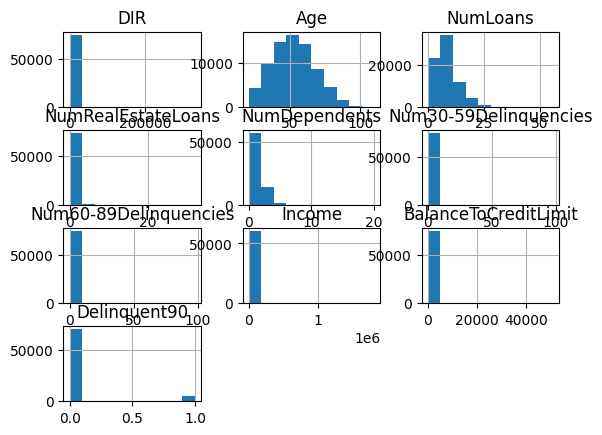

In [102]:
hists = train_df.hist(bins=10)

В качестве целевого признака используем колонку `Delinquent90` - просрочившие больше чем на 90 дней.

Отделите выделите из обучающего датасета целевой признак `y` и матрицу "объекты-признаки" `X`:

In [103]:
y = train_df['Delinquent90']
train_df.drop('Delinquent90', axis=1, inplace=True)

In [104]:
cols = train_df.columns

In [105]:
cols

Index(['DIR', 'Age', 'NumLoans', 'NumRealEstateLoans', 'NumDependents',
       'Num30-59Delinquencies', 'Num60-89Delinquencies', 'Income',
       'BalanceToCreditLimit'],
      dtype='object')

Посмотрите на количество объектов каждого из классов:

In [106]:
# ваш код здесь
y.value_counts()

Delinquent90
0    69987
1     5013
Name: count, dtype: int64

- Какие выводы можно сделать?
- Какое из значений метрики `accuracy` можно считать за базовое решение, которое будем пытаться побить?
- Насколько нам подходит метрика accuracy? Какие знаете более подходящие метрики?

**Ваши ответы здесь:**

1.   классы не сбаланстрованы
2.   Базовый уровень accuracy = 0.93316 (69987/75000). Если всегда будем говорить, что не было просрочек, то мы будем правы в 93.316% случаев
3. Accuracy не подходит, так как она не показывает насколько правильно аглогрит работает на каждом классе в отдельности. для несбалансированых данных лучше использовать Precision, recall, F-мера b ROC-AUC

### Заполнение пропусков - 1 балл

Продолжим предобработку данных. Посчитайте сколько пропусков в каждом из признаков:

In [107]:
# ваш код здесь
train_df.isna().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
dtype: int64

Заполните пропуски медианными значениями:

In [108]:
# ваш код здесь
train_df.fillna(train_df.mean(skipna=True, axis=0), inplace=True)

Проверьте еще раз количество оставшихся пропусков:

In [109]:
# ваш код здесь
train_df.isna().sum()

DIR                      0
Age                      0
NumLoans                 0
NumRealEstateLoans       0
NumDependents            0
Num30-59Delinquencies    0
Num60-89Delinquencies    0
Income                   0
BalanceToCreditLimit     0
dtype: int64

### Нормировка - 1 балл

Выполним масштабирование наших признаков так, чтобы их значение находилось в диапазоне `[0, 1]`:

In [110]:
train_df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
count,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.000000
mean,353.260293,52.595605,8.44976,1.016693,0.755966,0.428320,0.248000,6.740059e+03,6.276196
std,2117.237432,14.869729,5.15644,1.124019,1.093873,4.276439,4.239486,1.274278e+04,267.743321
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.176022,41.300000,5.00000,0.000000,0.000000,0.000000,0.000000,3.948961e+03,0.029703
50%,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,6.603940e+03,0.153720
75%,0.862650,63.100000,11.00000,2.000000,1.000000,0.000000,0.000000,7.406509e+03,0.560638
max,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533


In [111]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)

# трансформируйте все признаки, если затрудняетесь - посмотрите в документации sklearn

Удостоверьтесь, что теперь значения всех признаков находятся в диапазоне `[0,1]`:

In [112]:
# ваш код здесь

pd.DataFrame(train_df,columns=cols).describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
count,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04
mean,1.062117e-03,0.355806,0.150889,0.031772,0.037798,0.004371,0.002531,0.003733,1.233678e-04
std,6.365712e-03,0.167452,0.092079,0.035126,0.054694,0.043637,0.043260,0.007057,5.262884e-03
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,5.292291e-07,0.228604,0.089286,0.000000,0.000000,0.000000,0.000000,0.002187,5.838557e-07
50%,1.102970e-06,0.351351,0.142857,0.031250,0.000000,0.000000,0.000000,0.003658,3.021580e-06
75%,2.593654e-06,0.474099,0.196429,0.062500,0.050000,0.000000,0.000000,0.004102,1.102015e-05
max,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00


In [113]:
from sklearn import metrics

def print_scores(y,y_pred):
    print(f'f1_score {metrics.f1_score(y,y_pred)}')
    print(f'accuracy_score {metrics.accuracy_score(y,y_pred)}')
    print(f'roc_auc_score {metrics.roc_auc_score(y,y_pred)}')
    print(f'mean_squared_error {metrics.mean_squared_error(y,y_pred)}')

# Обучение моделей

## Дерево решений - 2 балла

Обучите решающее дерево, значения гиперпараметров выберите на ваш вкус, подбирать их не нужно:

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size = 0.3)

from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier()
clf_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [129]:
X_train.shape

(52500, 9)

Получите предсказания вашей модели и проверьте как она обучилась с помощью метрик `f1_score`, `accuracy_score`, `roc_auc_score`, `mean_squared_error`:

In [115]:
y_predict = clf_model.predict(X_test)

In [117]:
print_scores(y_test,y_predict)

f1_score 0.2307941653160454
accuracy_score 0.8945333333333333
roc_auc_score 0.5912752774285557
mean_squared_error 0.10546666666666667


Проверьте, не переобучились ли вы - сравните значения метрик на обучающей и валиадционной выборках:

In [118]:
y_train_predict = clf_model.predict(X_train)

In [119]:
print_scores(y_train,y_train_predict)

f1_score 0.9992944828559334
accuracy_score 0.9999047619047619
roc_auc_score 0.9994256116444407
mean_squared_error 9.523809523809524e-05


ПЕРЕОБУЧИЛСЯ МАКСИМАЛЬНО :-)

## Дерево решений + `GridSearch` - 2 балла

Выберите 2 гиперпараметра и по 3-5 значений для каждого из них:

In [120]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':['gini', 'entropy', 'log_loss'],
              'max_depth':[2,3,4,5,6,7],
              'splitter': ['best', 'random'],
              'max_features': ['sqrt', 'log2']}



# scoring = ['f1', 'accuracy', 'roc_auc', 'neg_mean_squared_error']

scoring = 'f1'

clf_model = DecisionTreeClassifier()
clf = GridSearchCV(clf_model, parameters,scoring=scoring, refit='f1', cv=10)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

print("Best score:", clf.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'splitter': 'best'}
Best score: 0.17776450201522412


Сравните значения метрик. Какой получили прирост?

In [121]:
clf_best_CV_model = DecisionTreeClassifier(**clf.best_params_)
clf_best_CV_model.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2')

In [122]:
y_predict_CV = clf_best_CV_model.predict(X_test)
print_scores(y_test,y_predict_CV)

f1_score 0.23842469398616287
accuracy_score 0.9364
roc_auc_score 0.5718486712345946
mean_squared_error 0.0636


ПРИРОСТА ОСОБЕННОГО НЕТ по ставнению с дефолтными параметрамаи классификатора

## Случайный лес - 2 балла

Обучите модель случайного леса:

In [131]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

Аналогично, посчитайте значение метрик:

In [132]:
y_predict_rfc = rfс.predict(X_test)

print_scores(y_test,y_predict_rfc)

f1_score 0.8149001536098309
accuracy_score 0.9785777777777778
roc_auc_score 0.8595930244609746
mean_squared_error 0.02142222222222222


In [133]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict_rfc))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21032
           1       0.93      0.72      0.81      1468

    accuracy                           0.98     22500
   macro avg       0.96      0.86      0.90     22500
weighted avg       0.98      0.98      0.98     22500



И проверьте на переобучение:

In [134]:
y_train_predict_rfc = rfс.predict(X_train)

print_scores(y_train,y_train_predict_rfc)

f1_score 0.8311770274534553
accuracy_score 0.9796190476190476
roc_auc_score 0.8698852274886453
mean_squared_error 0.02038095238095238


Какие выводы можем сделать при сравнении случайного леса и одного решающего дерева?

**Ваш ответ здесь:**

1.   переобучение у леса заметно ниже
2.   качетво предсказаний заметно лучше

## Градиентный бустинг - 2 балла

С помощью библиотеки LightGBM обучим градиентный бустинг на решающих деревьях:

In [158]:
from lightgbm import LGBMClassifier

lgbmc_model = LGBMClassifier(n_estimators=500, learning_rate=0.05)
lgbmc_model.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 3545, number of negative: 48955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 52500, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067524 -> initscore=-2.625363
[LightGBM] [Info] Start training from score -2.625363


LGBMClassifier(learning_rate=0.05, n_estimators=500)

Аналогично, посмотрим на метрики:

In [159]:
y_train_predict_lgbmc = lgbmc_model.predict(X_train)
y_test_predict_lgbmc = lgbmc_model.predict(X_test)

print("На трейн даннных")
print_scores(y_train,y_train_predict_lgbmc)

На трейн даннных
f1_score 0.45068027210884354
accuracy_score 0.9507809523809524
roc_auc_score 0.648495214294697
mean_squared_error 0.04921904761904762


In [160]:
print("На тест даннных")
print_scores(y_test,y_test_predict_lgbmc)

На тест даннных
f1_score 0.20735052111903454
accuracy_score 0.9357777777777778
roc_auc_score 0.5604269295626334
mean_squared_error 0.06422222222222222


Какие выводы можем сделать при сравнении случайного леса и градиентного бустинга? Что заметили?

**Ваш ответ здесь:**



1.   При маленьких значениях n_estimators = 500. Обучается бустинг заметно быстрее и качество предстказаний как на тестовой так  и на обучающей выборке заметно хуже, чем у леса. Сравнимо с единичным деревом
2.   При увеличении n_estimators  до 5000 время работы сравнимое с лесом, но при этом на лицо переобучение. Видимо надо аккуратно перебирать параметры через GridSearchCV






